# Predict tags on StackOverflow with linear models

In this assignment you will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Data

The following cell will download all data required for this assignment into the folder `week1/data`.

In [110]:
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

File data/train.tsv is already downloaded.
File data/validation.tsv is already downloaded.
File data/test.tsv is already downloaded.
File data/text_prepare_tests.tsv is already downloaded.


### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to platform only after running submitting function in the last part of this assignment. If you want to make partial submission, you can run that cell any time you want.

In [111]:
from grader import Grader

In [112]:
grader = Grader()

### Text preprocessing

For this and most of the following assignments you will need to use a list of stop words. It can be downloaded from *nltk*:

In [113]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ykirpichev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set is provided for Coursera's grading and doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [114]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [115]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [116]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [117]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [118]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow. In this task you'll write a function, which will be also used in the other assignments. 

**Task 1 (TextPrepare).** Implement the function *text_prepare* following the instructions. After that, run the function *test_text_prepare* to test it on tiny cases and submit it to Coursera.

In [119]:
import re

In [120]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text = REPLACE_BY_SPACE_RE.sub(" ", text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub("", text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([w for w in text.split() if w not in STOPWORDS])# delete stopwords from text
    return text

In [121]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [122]:
print(test_text_prepare())

Basic tests are passed.


Run your implementation for questions from file *text_prepare_tests.tsv* to earn the points.

In [123]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [124]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [125]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

In [126]:
y_train[:3]

array([list(['r']), list(['php', 'mysql']), list(['c#'])], dtype=object)

For each tag and for each word calculate how many times they occur in the train corpus. 

**Task 2 (WordsTagsCount).** Find 3 most popular tags and 3 most popular words in the train data and submit the results to earn the points.

In [127]:
from collections import Counter
from itertools import chain

# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

######################################
######### YOUR CODE HERE #############
######################################
# Dictionary of all tags from train corpus with their counts.
# tags_counts = Counter(chain.from_iterable([i for i in y_train]))

# # Dictionary of all words from train corpus with their counts.
# words_counts = Counter(chain.from_iterable([i.split(" ") for i in X_train]))

for i in y_train:
    for t in i:
        tags_counts[t] = tags_counts.get(t, 0) + 1

for line in X_train:
    for w in line.split():
        words_counts[w] = words_counts.get(w, 0) + 1

We are assuming that *tags_counts* and *words_counts* are dictionaries like `{'some_word_or_tag': frequency}`. After applying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`. The grader gets the results in the following format (two comma-separated strings with line break):

    tag1,tag2,tag3
    word1,word2,word3

Pay attention that in this assignment you should not submit frequencies or some additional information.

In [128]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_my_bag_of_words*.

In [158]:
DICT_SIZE = 5000


INDEX_TO_WORDS = {i:pair[0] for i, pair in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]) }
WORDS_TO_INDEX = {w:i for i,w in INDEX_TO_WORDS.items()} ####### YOUR CODE HERE #######
####### YOUR CODE HERE #######
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    for w in text.split():
        if w in words_to_index:
            idx = words_to_index[w]
            result_vector[idx] = 1
    return result_vector

In [159]:
for i,w in INDEX_TO_WORDS.items():
    print(i, w)

0 using
1 php
2 java
3 file
4 javascript
5 error
6 get
7 c#
8 python
9 string
10 array
11 data
12 jquery
13 value
14 function
15 object
16 class
17 use
18 c++
19 list
20 method
21 multiple
22 text
23 image
24 page
25 rails
26 form
27 create
28 html
29 type
30 code
31 set
32 working
33 database
34 add
35 convert
36 mysql
37 json
38 c
39 server
40 variable
41 android
42 values
43 aspnet
44 way
45 application
46 change
47 button
48 find
49 django
50 one
51 without
52 windows
53 cannot
54 table
55 call
56 files
57 ajax
58 check
59 time
60 name
61 two
62 ruby
63 getting
64 date
65 web
66 make
67 input
68 user
69 xml
70 app
71 another
72 element
73 custom
74 event
75 api
76 access
77 url
78 number
79 spring
80 view
81 sql
82 return
83 mvc
84 select
85 google
86 query
87 inside
88 exception
89 display
90 column
91 read
92 loop
93 swift
94 new
95 work
96 remove
97 load
98 r
99 objects
100 property
101 line
102 cant
103 pass
104 click
105 framework
106 update
107 script
108 vs
109 post
110 null

1627 lookup
1628 textboxes
1629 localstorage
1630 comment
1631 logic
1632 feature
1633 chars
1634 inherited
1635 glassfish
1636 padding
1637 master
1638 referenceerror
1639 align
1640 lost
1641 additional
1642 prefix
1643 chartjs
1644 restart
1645 c++11
1646 deployment
1647 webconfig
1648 pythons
1649 iteration
1650 percentage
1651 terminal
1652 submission
1653 arduino
1654 merging
1655 online
1656 nonobject
1657 makes
1658 jsoup
1659 pool
1660 constants
1661 implicit
1662 transform
1663 ldap
1664 27
1665 optimize
1666 sharing
1667 emails
1668 enums
1669 thumbnail
1670 underscore
1671 beginning
1672 square
1673 postgres
1674 fancybox
1675 pil
1676 tensorflow
1677 cordova
1678 constraints
1679 innerhtml
1680 md5
1681 combo
1682 dojo
1683 javalangnoclassdeffounderror
1684 direct
1685 uitextview
1686 pure
1687 clean
1688 graphics
1689 purpose
1690 fetching
1691 bash
1692 completely
1693 simulate
1694 unresolved
1695 arc
1696 updates
1697 obtain
1698 p
1699 concurrent
1700 rewrite
1701 man

3474 unicodedecodeerror
3475 construction
3476 backslash
3477 focused
3478 pom
3479 erase
3480 simply
3481 specification
3482 subdomains
3483 mdb
3484 establish
3485 overhead
3486 _files
3487 activation
3488 tabbar
3489 techniques
3490 pick
3491 contexts
3492 expose
3493 oriented
3494 uinavigationbar
3495 fopen
3496 released
3497 prestashop
3498 hdfs
3499 density
3500 redraw
3501 exercise
3502 previously
3503 processstart
3504 profiling
3505 yield
3506 japanese
3507 restarting
3508 timestamps
3509 __init__
3510 popover
3511 curve
3512 minimize
3513 ticks
3514 rabbitmq
3515 crossbrowser
3516 assemblies
3517 crossdomain
3518 ansi
3519 gmt
3520 j2ee
3521 timeline
3522 cycle
3523 todays
3524 salesforce
3525 caller
3526 jmeter
3527 geocoding
3528 overlap
3529 imagefield
3530 rolling
3531 activex
3532 hy000
3533 movie
3534 xmlreader
3535 nesting
3536 mass
3537 seo
3538 javac
3539 aligned
3540 existence
3541 sidebar
3542 integral
3543 traverse
3544 transformation
3545 scrolled
3546 solutions


In [160]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [161]:
print(test_my_bag_of_words())

Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

In [162]:
from scipy import sparse as sp_sparse

In [163]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

**Task 3 (BagOfWords).** For the 11th row in *X_train_mybag* find how many non-zero elements it has. In this task the answer (variable *non_zero_elements_count*) should be a number, e.g. 20.

In [164]:
row = X_train_mybag[10].toarray()[0]
print(X_train_mybag[10].toarray())
print(sum(row))
non_zero_elements_count = int(sum(row)) ####### YOUR CODE HERE #######

grader.submit_tag('BagOfWords', str(non_zero_elements_count))

[[0. 0. 0. ... 0. 0. 0.]]
7.0
Current answer for task BagOfWords is:
 7...


#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

In [165]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [166]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=5, token_pattern=r'(\S+)') ####### YOUR CODE HERE #######
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it. 

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [138]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [139]:
######### YOUR CODE HERE #############
print("c#" in set(tfidf_reversed_vocab.values()))
print("c++" in set(tfidf_reversed_vocab.values()))

True
True


If you can't find it, we need to understand how did it happen that we lost them? It happened during the built-in tokenization of TfidfVectorizer. Luckily, we can influence on this process. Get back to the function above and use '(\S+)' regexp as a *token_pattern* in the constructor of the vectorizer.  

Now, use this transormation for the data and check again.

In [140]:
######### YOUR CODE HERE #############
X_train_tfidf[:2, :].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [141]:
from sklearn.preprocessing import MultiLabelBinarizer

In [142]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [167]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [168]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.

    ######################################
    ######### YOUR CODE HERE #############
    ######################################    
    model = LogisticRegression()
    model = OneVsRestClassifier(model)
    model.fit(X_train, y_train)
    return model

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [169]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

/home/ykirpichev/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ykirpichev/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [170]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [171]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [172]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [173]:
def print_evaluation_scores(y_val, predicted):
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    print("accuracy: ", accuracy_score(y_val, predicted))
    print("f1-score: ", f1_score(y_val, predicted, average='macro'))
    print("precision: ", average_precision_score(y_val, predicted, average='macro'))
    print("recal: ", recall_score(y_val, predicted, average='macro'))

In [174]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
accuracy:  0.3617
f1-score:  0.507931566722554
precision:  0.3486000949198905
recal:  0.41437809897635847
Tfidf
accuracy:  0.33393333333333336
f1-score:  0.4457086744251823
precision:  0.3020305673777862
recal:  0.3404350526987695


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [175]:
from metrics import roc_auc
%matplotlib inline

In [176]:
print(len(tags_counts))

100


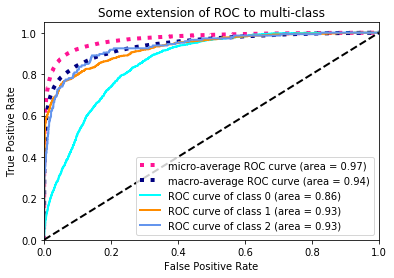

In [177]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

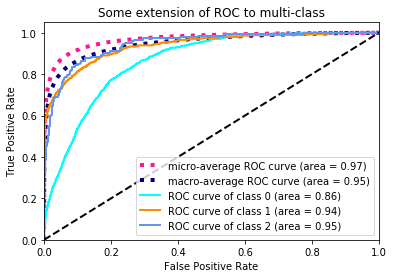

In [178]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

You also could try other improvements of the preprocessing / model, if you want. 

/home/ykirpichev/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


penalty=l1, c=0.1, f1=0.48025305295845555
penalty=l1, c=0.30000000000000004, f1=0.5097170445870742
penalty=l1, c=0.5000000000000001, f1=0.5152231912677359
penalty=l1, c=0.7000000000000001, f1=0.5183276049291092
penalty=l1, c=0.9000000000000001, f1=0.5193839344620157
penalty=l1, c=1.1000000000000003, f1=0.5206555445577856
penalty=l1, c=1.3000000000000003, f1=0.5235632090003542
penalty=l1, c=1.5000000000000004, f1=0.525127482312544
penalty=l1, c=1.7000000000000004, f1=0.5262210592718826
penalty=l1, c=1.9000000000000004, f1=0.5258455487867415
penalty=l1, c=2.1000000000000005, f1=0.5265672527702889
penalty=l1, c=2.3000000000000007, f1=0.5265793493686785


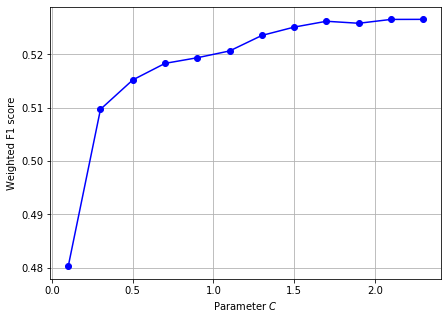

/home/ykirpichev/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


penalty=l2, c=0.1, f1=0.43460355352614377
penalty=l2, c=0.30000000000000004, f1=0.48310348912406526
penalty=l2, c=0.5000000000000001, f1=0.4961832637124125
penalty=l2, c=0.7000000000000001, f1=0.5021235747065919
penalty=l2, c=0.9000000000000001, f1=0.5059717720040356
penalty=l2, c=1.1000000000000003, f1=0.5090646684920628
penalty=l2, c=1.3000000000000003, f1=0.5109600650003095
penalty=l2, c=1.5000000000000004, f1=0.5121967088091088
penalty=l2, c=1.7000000000000004, f1=0.5128345376441527
penalty=l2, c=1.9000000000000004, f1=0.5132011907594553
penalty=l2, c=2.1000000000000005, f1=0.5146533189175152
penalty=l2, c=2.3000000000000007, f1=0.5150037077678156


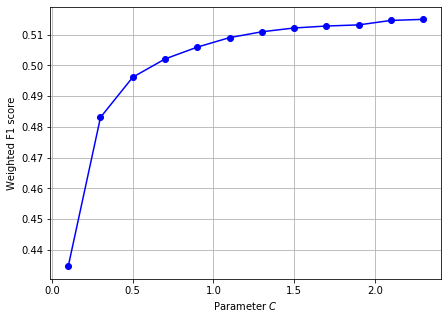

In [183]:
######################################
######### YOUR CODE HERE #############
######################################
def train_classifier_c(X_train, y_train, c, penalty='l2'):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.  
    model = LogisticRegression(C=c, penalty=penalty, solver='liblinear')
    model = OneVsRestClassifier(model)
    model.fit(X_train, y_train)
    return model

import matplotlib.pyplot as plt

c_range = np.arange(0.1, 2.5, 0.2)
for penalty in ('l1', 'l2'):
    hist = []
    for c in c_range:
        
        m = train_classifier_c(X_train_mybag, y_train, c=c, penalty=penalty)
        y_val_predicted = m.predict(X_val_mybag)
#         y_val_predicted_ = m.decision_function(X_val_mybag)
        f1 = f1_score(y_val, y_val_predicted, average='macro')
        print("penalty={}, c={}, f1={}".format(penalty, c, f1))
        hist.append(f1)

    plt.figure(figsize=(7,5))
    plt.plot(c_range, hist, color='blue', marker='o')
    plt.grid(True)
    plt.xlabel('Parameter $C$')
    plt.ylabel('Weighted F1 score')
    plt.show()


When you are happy with the quality, create predictions for *test* set, which you will submit to Coursera.

/home/ykirpichev/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


penalty=l1, c=0.1, f1=0.4280232675360842
penalty=l1, c=0.30000000000000004, f1=0.4788125847209839
penalty=l1, c=0.5000000000000001, f1=0.49484651832227955
penalty=l1, c=0.7000000000000001, f1=0.5029463733146656
penalty=l1, c=0.9000000000000001, f1=0.5069527021364274
penalty=l1, c=1.1000000000000003, f1=0.5105527850636817
penalty=l1, c=1.3000000000000003, f1=0.5131448121253687
penalty=l1, c=1.5000000000000004, f1=0.5139144375100106


/home/ykirpichev/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


penalty=l1, c=1.7000000000000004, f1=0.5149091461963899


/home/ykirpichev/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


penalty=l1, c=1.9000000000000004, f1=0.5158609165130654
penalty=l1, c=2.1000000000000005, f1=0.5174958814656268
penalty=l1, c=2.3000000000000007, f1=0.5185494050509099


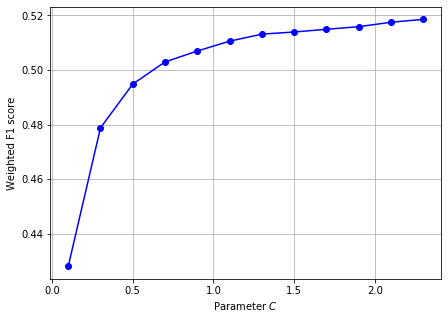

/home/ykirpichev/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


penalty=l2, c=0.1, f1=0.14076428055458623


/home/ykirpichev/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


penalty=l2, c=0.30000000000000004, f1=0.32244603235944075


/home/ykirpichev/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


penalty=l2, c=0.5000000000000001, f1=0.38861364469943427
penalty=l2, c=0.7000000000000001, f1=0.4213083919634235
penalty=l2, c=0.9000000000000001, f1=0.4382284147254133
penalty=l2, c=1.1000000000000003, f1=0.4511729407925244
penalty=l2, c=1.3000000000000003, f1=0.460050770234054
penalty=l2, c=1.5000000000000004, f1=0.4670171956655665
penalty=l2, c=1.7000000000000004, f1=0.4732211455737661
penalty=l2, c=1.9000000000000004, f1=0.47697578492863085
penalty=l2, c=2.1000000000000005, f1=0.4809344240835991
penalty=l2, c=2.3000000000000007, f1=0.4838574031569691


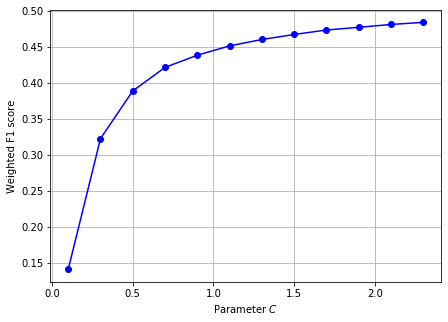

In [184]:
c_range = np.arange(0.1, 2.5, 0.2)
for penalty in ('l1', 'l2'):
    hist = []
    for c in c_range:
        
        m = train_classifier_c(X_train_tfidf, y_train, c=c, penalty=penalty)
        y_val_predicted = m.predict(X_val_tfidf)
#         y_val_predicted_ = m.decision_function(X_val_mybag)
        f1 = f1_score(y_val, y_val_predicted, average='macro')
        print("penalty={}, c={}, f1={}".format(penalty, c, f1))
        hist.append(f1)

    plt.figure(figsize=(7,5))
    plt.plot(c_range, hist, color='blue', marker='o')
    plt.grid(True)
    plt.xlabel('Parameter $C$')
    plt.ylabel('Weighted F1 score')
    plt.show()

In [185]:
best_model = train_classifier_c(X_train_mybag, y_train, c=2.5, penalty='l1')
# y_val_predicted = best_model.predict(X_val_tfidf)
test_predictions = best_model.predict(X_test_mybag) ######### YOUR CODE HERE #############
test_pred_inversed = mlb.inverse_transform(test_predictions)

print(test_pred_inversed)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

[('mysql', 'php'), ('javascript',), (), ('javascript', 'jquery'), ('android', 'java'), ('php', 'xml'), ('ajax', 'json', 'web-services'), ('java', 'swing'), ('python',), ('html',), ('jquery',), (), ('php',), ('ruby-on-rails',), ('c#', 'linq', 'list'), ('python',), ('c',), ('ajax', 'html', 'javascript', 'jquery', 'ruby-on-rails', 'ruby-on-rails-3'), (), ('linux', 'sockets'), ('python',), ('pandas', 'python'), ('c++',), (), ('php', 'wordpress'), ('c++',), ('ruby', 'ruby-on-rails'), ('c#', 'wpf'), ('numpy', 'python'), ('r',), ('javascript', 'jquery'), ('c#',), ('javascript',), ('python',), ('hibernate', 'java', 'spring'), (), ('c#', 'wpf', 'xaml'), ('javascript',), ('php',), ('java',), ('java', 'sockets'), ('asp.net', 'c#'), (), ('eclipse', 'java'), ('c#',), ('php',), ('c#',), (), (), ('c++', 'eclipse'), ('javascript', 'jquery'), ('c#',), ('arrays', 'c++'), ('javascript',), ('javascript',), (), ('python',), ('asp.net', 'c#'), ('ios', 'javascript', 'objective-c'), ('dom', 'html', 'javascrip

### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [208]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    est = classifier_tfidf.estimators_[tags_classes.index(tag)]
    # Extract feature coefficients from the estimator. 
    pos_idx = est.coef_.argsort()[0][-1:-6:-1]
    neg_idx = est.coef_.argsort()[0][:5]
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    top_positive_words = [index_to_words[idx] for idx in pos_idx] # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[idx] for idx in neg_idx] # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [209]:
est = classifier_tfidf.estimators_[mlb.classes.index('c++')]

In [210]:
print(est.coef_[0, est.coef_.argsort()[0][-1:-6:-1]])
print(est.coef_[0, est.coef_.argsort()[0][:5]])


[20.50862243 10.02833809  7.54829473  6.61059617  6.1407545 ]
[-8.51003613 -7.95230178 -7.26214843 -7.12674021 -6.71078114]


In [211]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	c, malloc, scanf, printf, gcc
Top negative words:	java, php, python, javascript, c#

Tag:	c++
Top positive words:	c++, qt, boost, mfc, opencv
Top negative words:	java, php, python, javascript, c#

Tag:	linux
Top positive words:	linux, ubuntu, c, address, signal
Top negative words:	javascript, c#, jquery, array, method



### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [ ]:
grader.status()

In [188]:
STUDENT_EMAIL = 'ykirpichev@gmail.com'# EMAIL 
STUDENT_TOKEN = 'zTIjIj4ohGbAreAT' # TOKEN 
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	ajax,json,web-services
7	...


If you want to submit these answers, run cell below

In [189]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
